<a href="https://colab.research.google.com/github/evillag/TEC-ML-2022-1/blob/main/TP3/TP3_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.distributions import multivariate_normal
import random
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_moons

# Curso de Aprendizaje Automático
# Trabajo Practico 3: Implementación del algoritmo K-medias
**Escuela de Ingeniería en Computación | Instituto Tecnológico de Costa Rica**

Realizado por
*   Luis Badilla Ortiz
*   William Jiménez García
*   Esteban Villalobos Gómez

Fecha de entrega
*  31 de mayo del 2022

Entrega
* Un archivo .zip con el código fuente LaTeX o Lyx, el pdf, y un notebook en jupyter, debidamente documentado, con una función definida por ejercicio. A través del TEC-digital.

Modo de trabajo
* Grupos de 3 personas.

# Resumen de resultados despues de 10 corridas

## Conjuntos con clases traslapadas


| Algortimo             | Accuracy % | Std. Acc. | Tiempo | Std. Tiempo |
|------                 | -----      | --------- | ------ | --------- |
| K-Medias (Euclidean)  | 91.8       | 2.071     | 0.007  | 0.002     | 
| K-Medias (Manhattan)  | 91.15      | 2.161     | 0.005  | 0.003     |
| Corte de Grafos       | 50.8       | 0.483     | 0.51   | 0.008     |


## Conjuntos de medias lunas

| Algortimo             | Accuracy % | Std. Acc. | Tiempo | Std. Tiempo |
|------                 | -----      | --------- | ------ | --------- |
| K-Medias (Euclidean)  | 75.16      | 0.572     | 0.011  | 0.003     | 
| K-Medias (Manhattan)  | 80.6       | 0.267     | 0.006  | 0.003     |
| Corte de Grafos       | 100.0      | 0.0       | 3.994  | 0.085     |


# 1 - Creación de datos

In [ ]:
def createData(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [26, 26], stds1 = [3, 3, 2, 2], stds2 = [2, 2, 1, 1]):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation[0,1] and covariance[2,3] for samples, class 1
    @param stds2, standard deviation[0,1] and covariance[2,3] for samples, class 2    
    """
    # Create Data Class 1
    covarianceMatrix = torch.tensor([[stds1[0], stds1[2]], 
                                     [stds1[3], stds1[1]]]).float()
    samplesClass1 = createDataOneClass(torch.tensor(mean1).float(), covarianceMatrix, numberSamplesPerClass)
    
    # Create Data Class 2
    covarianceMatrix = torch.tensor([[stds2[0], stds2[2]], 
                                     [stds2[3], stds2[1]]]).float()
    samplesClass2 = createDataOneClass(torch.tensor(mean2).float(), covarianceMatrix, numberSamplesPerClass)

    #Contatenate all samples
    samplesAll = torch.cat((samplesClass1, samplesClass2), 1)
    
    #Create targets
    targetsClass0 = torch.zeros(1, numberSamplesPerClass)
    targetsClass1 = torch.ones(1, numberSamplesPerClass)

    #Contatenate all targets
    targetsAll = torch.cat((targetsClass0, targetsClass1), 1)[0]
    
    return (targetsAll, samplesAll)

def createDataOneClass(means, covarianceMatrix, numberSamples):
    """
    Creates data with gaussian distribution
    """
    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)

    # Create the samples
    samples = multiGaussGenerator.sample(torch.Size([numberSamples])).T
    return samples

def plotData(dataX, dataY, label="Data", marker="o", show=True, title=""):
    """
    Plot the given data
    """
    plt.scatter(dataX, dataY, label=label, marker=marker)
    plt.legend(loc="upper left")
    plt.title(title)
    if(show):
      plt.show()
  
def plotSampleData(SamplesAll, TargetsAll, show_separated=True, show_plot=True, title=""):
    """
    Plot data by class or whole data
    """
    if(show_separated):
      # Show data with labels and symbols
      DataClass0 = SamplesAll[:, TargetsAll==0]
      DataClass1 = SamplesAll[:, TargetsAll==1]
      plotData(DataClass0[0], DataClass0[1], label="Class 1 Samples", marker="x", show=False)
      plotData(DataClass1[0], DataClass1[1], label="Class 2 Samples", show=show_plot, title=title)
    else:
      # Show whole data without labels and symbols
      plotData(SamplesAll[0], SamplesAll[1], label="Samples", show=show_plot, title=title)


def plotError(loss_arr, title='Training Error'):
  fig = plt.figure()    
  plt.xlabel("Iteration")
  plt.ylabel("Error %")
  plt.title(title)
  plt.plot(loss_arr)
  plt.show()
  fig.clear()

# 1.1.a.1 - Conjuntos de datos separados

In [ ]:
# Easy separation Data
(TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 100, mean1 = [5,10], mean2 = [25, 10], stds1 = [10, 10, 9, 9], stds2 = [9, 9, -8.5, -8.5]) 

# 1.1.b - Graficación de los datos

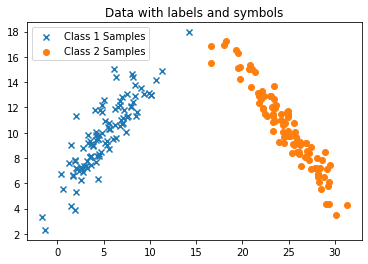

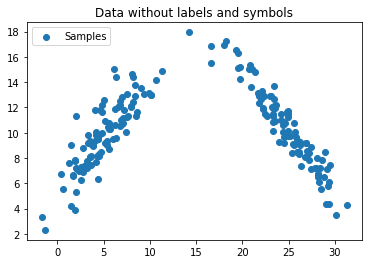

In [ ]:
# Show data with labels and symbols
plotSampleData(SamplesAll, TargetsAll, show_separated=True, title="Data with labels and symbols")

# Show whole data without labels and symbols
plotSampleData(SamplesAll, TargetsAll, show_separated=False, title="Data without labels and symbols")

# 1.1.a.2 - Conjuntos de datos traslapados

In [ ]:
# Hard separation data
(TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 100, mean1 = [15,15], mean2 = [27, 15], stds1 = [20, 20, 19, 19], stds2 = [19, 19, -17, -17]) 

# 1.1.b - Graficación de los datos

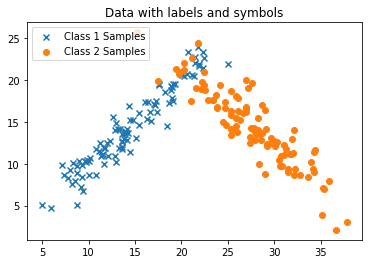

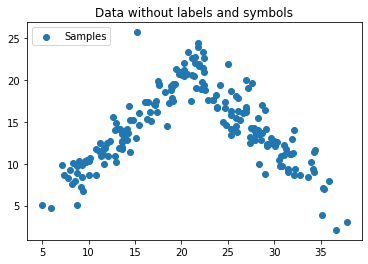

In [ ]:
# Show data with labels and symbols
plotSampleData(SamplesAll, TargetsAll, show_separated=True, title="Data with labels and symbols")

# Show whole data without labels and symbols
plotSampleData(SamplesAll, TargetsAll, show_separated=False, title="Data without labels and symbols")

# 1.2 - Implementación de algoritmo K-Medias

In [ ]:
def predict(W):
  predicted = torch.ones(W.shape[0])
  predicted[W[:, 0] == 1] = 0
  return predicted


def Test_K_Means(W, targets=TargetsAll):

  predicted = predict(W)
  prediction1 = predicted == targets
  prediction2 = predicted != targets

  total = torch.max(torch.count_nonzero(prediction1), torch.count_nonzero(prediction2))
  cant = targets.shape[0]
  accuracy = round((total / cant * 100).item(), 5)

  return accuracy


def Train_K_Means(iterations=10, euclidean=True, show_plot=False):
  """
  Implementation of the K_Means algorithm
  It was implemented only using matrix operations
  @param iterations, the maximum number of iterations
  @param euclidean, defines if use L2 or L1 distance 
  """
  allLosses = []
  
  # STEP 1: Initilize Means randomly
  # Means = torch.rand(2, 2)
  Means = SamplesAll.T[torch.randint(len(SamplesAll.T), (2,))].T

  Means_bck = torch.zeros(2, 2)

  # Get rows and cols size
  rows, cols = SamplesAll.shape
  
  # P = 1 to Manhattan distance
  # P = 2 to Euclidean distance
  P = 2 if euclidean else 1

  for iteration in range(iterations):
    #print(f'================== Iteration: {iteration + 1} ==================')
    #print('Means:', Means)

    # Avoid continue if means didn't change
    if((Means != Means_bck).count_nonzero().item() == 0):
      #print("Attention: Means didn't change, stopping process")
      break
    else:
      Means_bck = Means.clone()

    # STEP 2.A: LABELING SAMPLES
    # Get the distance to first mean
    distance1stMean = torch.norm(SamplesAll.T - Means[:, 0], P, dim=1)

    # Get the distance to second mean
    distance2ndMean = torch.norm(SamplesAll.T - Means[:, 1], P, dim=1)

    # Choose minimum distance to means for each sample
    minMatrix = torch.min(distance1stMean, distance2ndMean)

    # STEP 2.B: MINIMIZING ERROR FUNCTION
    # Create W Matrix
    W = torch.cat(((minMatrix == distance1stMean).view(cols,1), (minMatrix == distance2ndMean).view(cols,1)), dim=1).float()

    # Count elements in each class 
    class0Qty = torch.sum(W[:, 0])
    class1Qty = torch.sum(W[:, 1])

    class0Qty = class0Qty if class0Qty != 0 else 1 # To avoid zero division
    class1Qty = class1Qty if class1Qty != 0 else 1 # To avoid zero division 

    newMult = torch.cat((W[:, 0].unsqueeze(1), W[:, 0].unsqueeze(1)), 1) 
    mult1 = newMult * SamplesAll.T
    labelEst1 = mult1[mult1.nonzero(as_tuple=True)].reshape((int(class0Qty.item()), 2))

    newMult = torch.cat((W[:, 1].unsqueeze(1), W[:, 1].unsqueeze(1)), 1) 
    mult2 = newMult * SamplesAll.T
    labelEst2 = mult2[mult2.nonzero(as_tuple=True)].reshape((int(class1Qty.item()), 2))

    target1 = torch.zeros(1, labelEst1.shape[0]).squeeze(0)
    target2 = torch.ones(1, labelEst2.shape[0]).squeeze(0)
    target = torch.cat((target1, target2), 0)
    labelEst = torch.cat((labelEst1, labelEst2), 0)

    if(show_plot):
      # Plot the proccess
      plotSampleData(labelEst.T, target, show_separated=True, show_plot=False)
      plotData(Means[0], Means[1], label="Means", marker='s') # Show means position
    
    # Calc new Means
    Means[:, 0] = W[:, 0].view(1, cols).mm(SamplesAll.T) / class0Qty
    Means[:, 1] = W[:, 1].view(1, cols).mm(SamplesAll.T) / class1Qty

    # This is not required for training, it is only used to plot the loss later
    allLosses.append(100.0 - Test_K_Means(W, TargetsAll))

  # STEP 3: MATRIX W TO PREDICT LABELS
  return W, allLosses


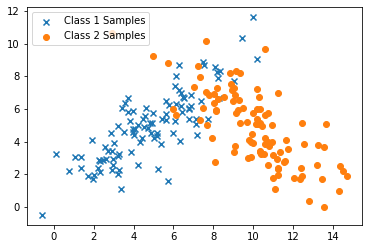

In [ ]:
# Create Data
(TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 100, mean1 = [5,5], mean2 = [10, 5], stds1 = [5, 5, 4.2, 4.2], stds2 = [6, 6, -5, -5]) 
plotSampleData(SamplesAll, TargetsAll, show_separated=True)

# 1.2.a - Usando distancia Euclideana

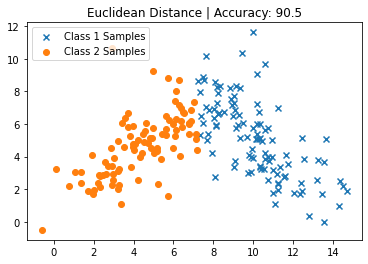

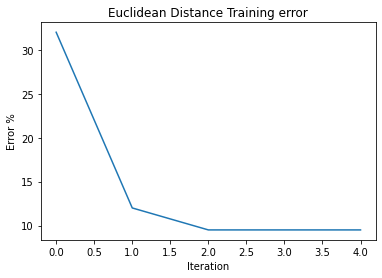


Accuracy: 90.5 %


In [ ]:
# Train W Matrix
W, allLosses = Train_K_Means(euclidean=True, show_plot=False)

# Calc Accuracy
accuracy = Test_K_Means(W, TargetsAll)

# Plot Predicted Labels
plotSampleData(SamplesAll, predict(W), show_separated=True, show_plot=True, title=f"Euclidean Distance | Accuracy: {accuracy}")

plotError(allLosses, "Euclidean Distance Training error")
print(f'\nAccuracy: {accuracy} %')

# 1.2.b - Usando distancia de Manhattan

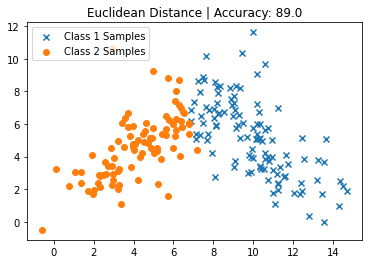

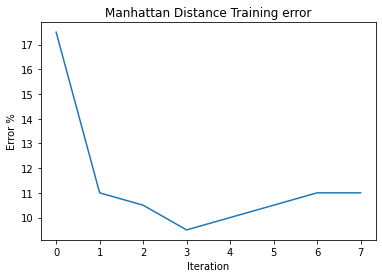


Accuracy: 89.0 %


In [ ]:
# Train W Matrix
W, allLosses = Train_K_Means(euclidean=False, show_plot=False)

# Calc Accuracy
accuracy = Test_K_Means(W, TargetsAll)

# Plot Predicted Labels
plotSampleData(SamplesAll, predict(W), show_separated=True, show_plot=True, title=f"Euclidean Distance | Accuracy: {accuracy}")

plotError(allLosses, "Manhattan Distance Training error")
print(f'\nAccuracy: {accuracy} %')

# 1.2.c - Resultados


================== Iteration: 1 ==================



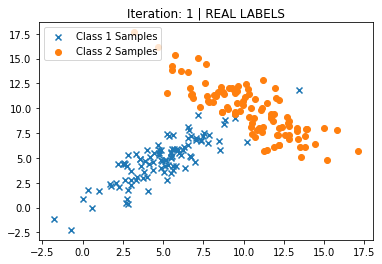

-----------------------------------------------


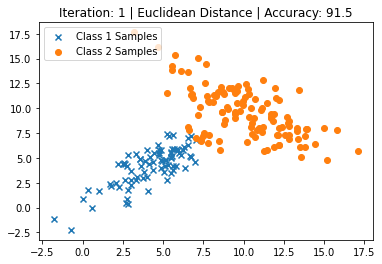

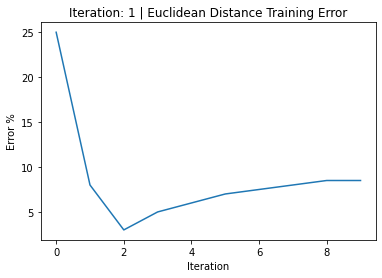

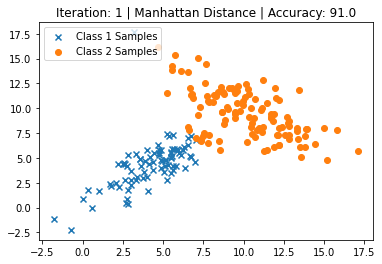

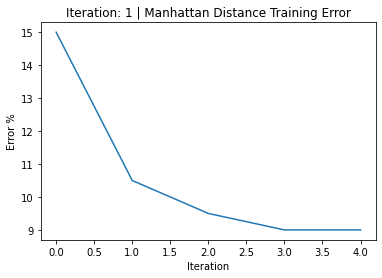


================== Iteration: 2 ==================



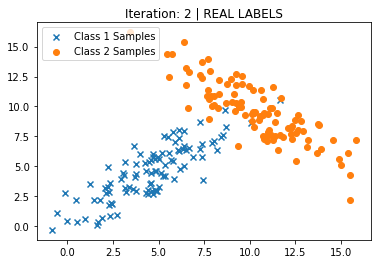

-----------------------------------------------


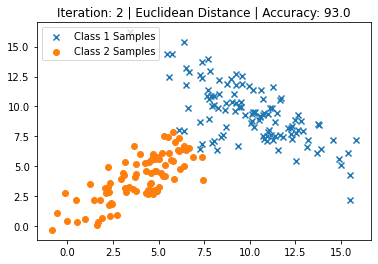

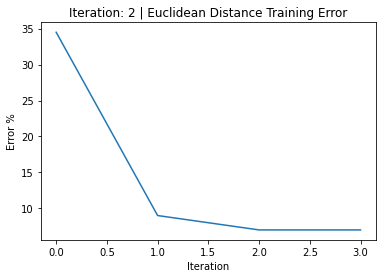

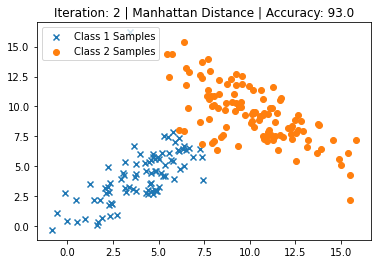

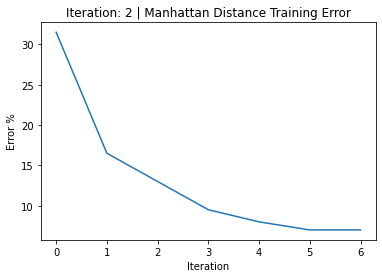


================== Iteration: 3 ==================



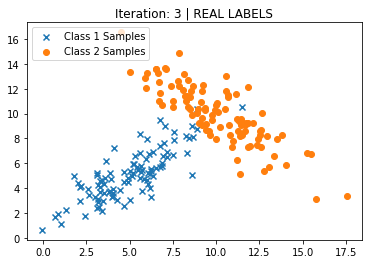

-----------------------------------------------


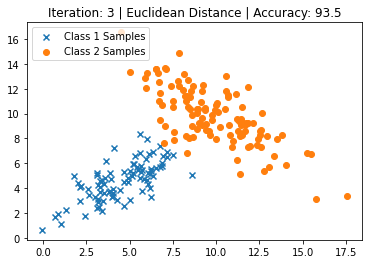

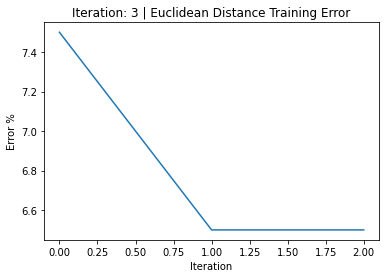

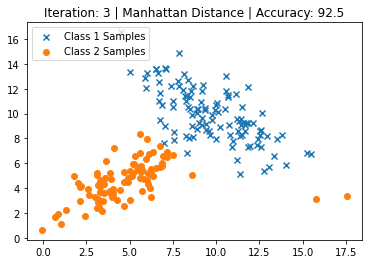

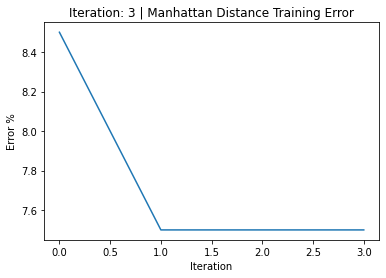


================== Iteration: 4 ==================



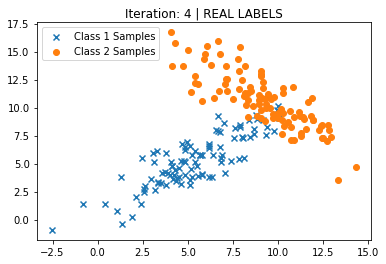

-----------------------------------------------


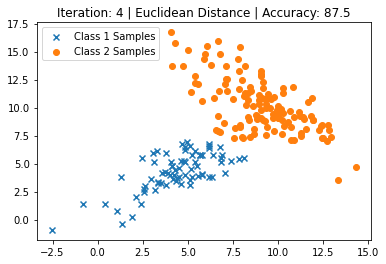

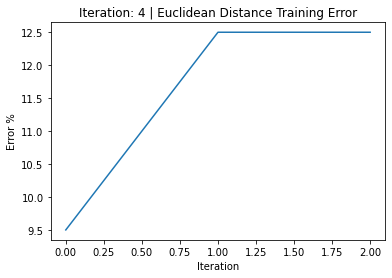

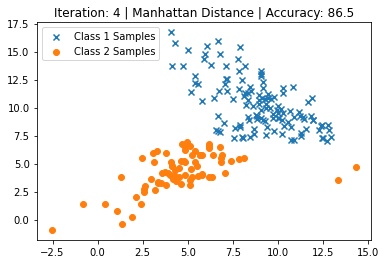

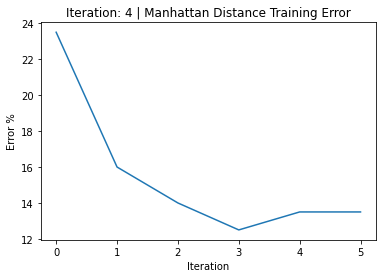


================== Iteration: 5 ==================



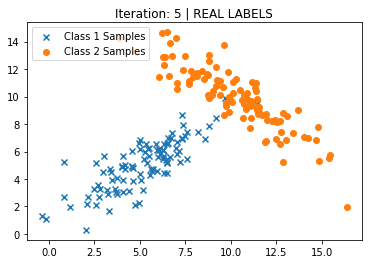

-----------------------------------------------


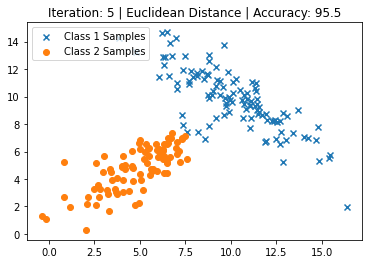

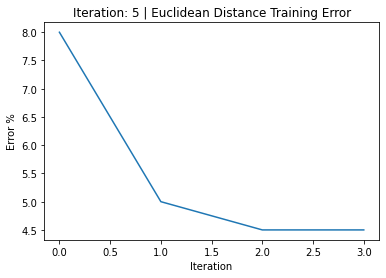

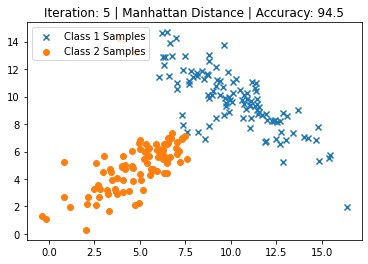

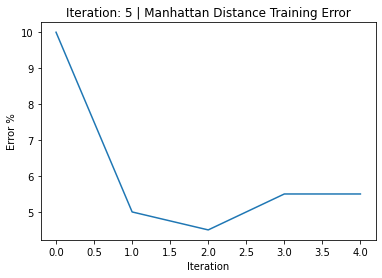


================== Iteration: 6 ==================



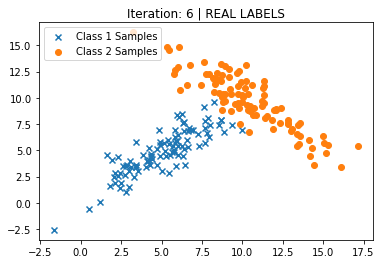

-----------------------------------------------


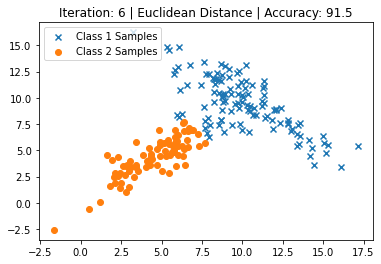

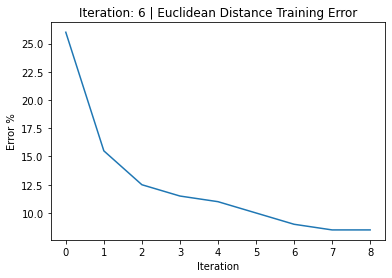

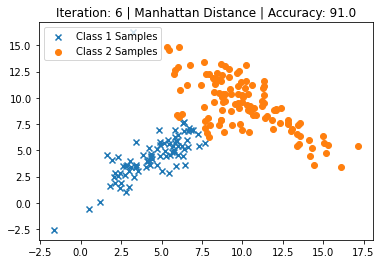

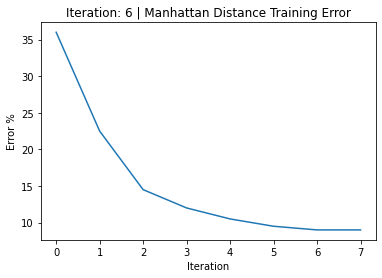


================== Iteration: 7 ==================



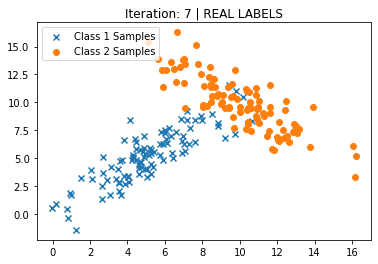

-----------------------------------------------


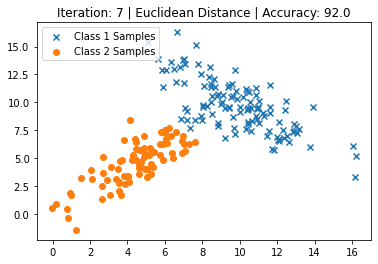

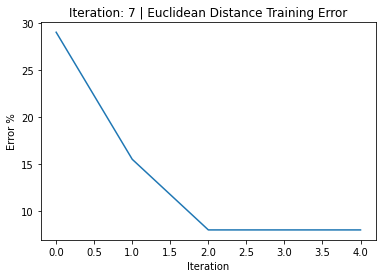

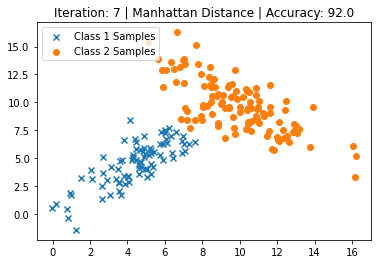

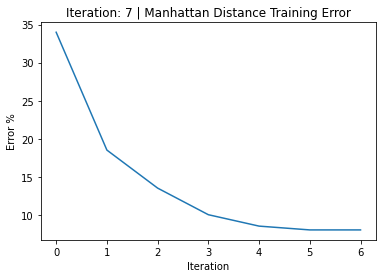


================== Iteration: 8 ==================



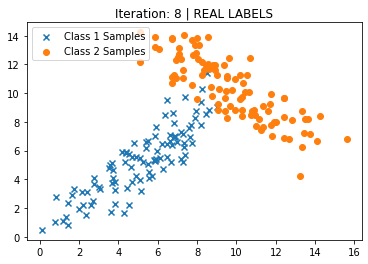

-----------------------------------------------


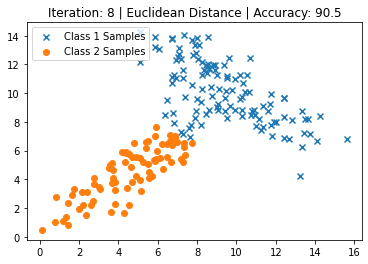

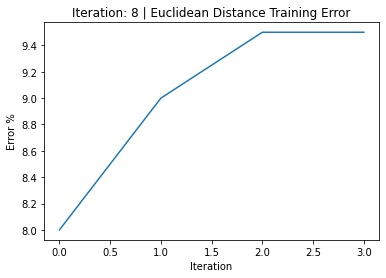

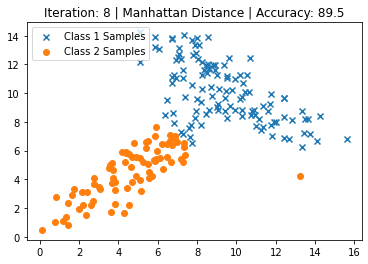

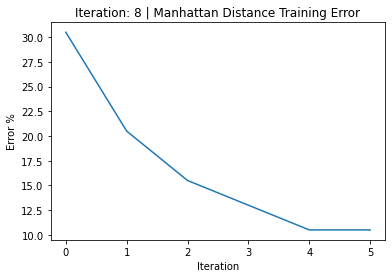


================== Iteration: 9 ==================



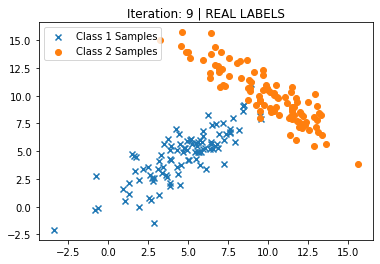

-----------------------------------------------


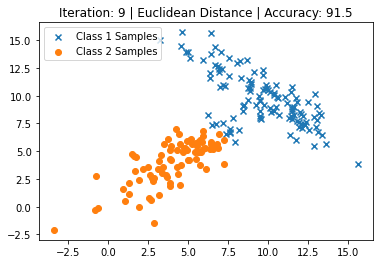

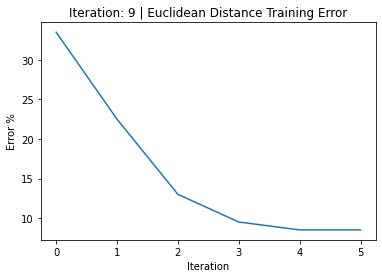

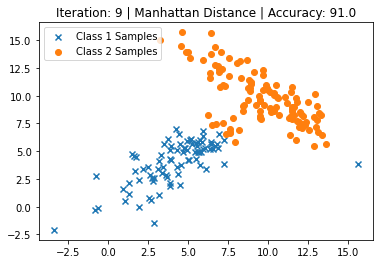

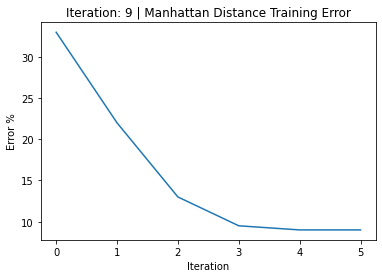


================== Iteration: 10 ==================



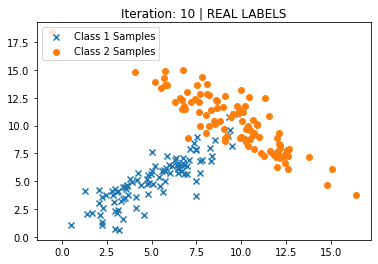

-----------------------------------------------


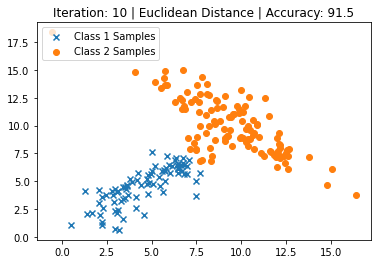

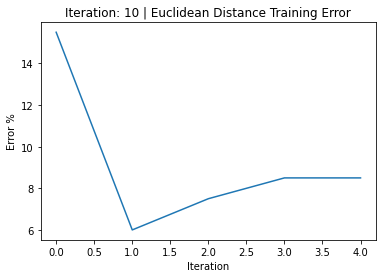

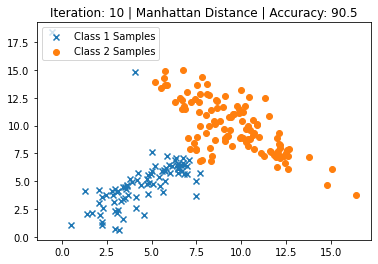

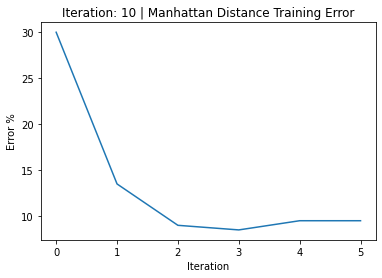


EUCLIDEAN DISTANCE
== Accuracy ==
Std: 2.071
Mean: 91.8
== Time ==
Std: 0.002
Mean: 0.007

MANHATTAN DISTANCE
== Accuracy ==
Std: 2.161
Mean: 91.15
== Time ==
Std: 0.003
Mean: 0.005


In [ ]:
# Number of iterations
iterations = 10

# To save accuraccies
accuracies = torch.zeros(2, iterations)

# To save times
times = torch.zeros(2, iterations)

for iteration in range(iterations):
  print(f'\n================== Iteration: {iteration + 1} ==================\n')
  
  # Create Data
  (TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 100, mean1 = [5,5], mean2 = [10, 10], stds1 = [5, 5, 4.2, 4.2], stds2 = [6, 6, -5, -5]) 

  # Plot real data
  plotSampleData(SamplesAll, TargetsAll, show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | REAL LABELS")

  # == EUCLIDEAN DISTANCE == #
  # Train W Matrix Using: [Euclidean Distance]
  start_time = time.time()
  W, allLosses = Train_K_Means(euclidean=True, show_plot=False)
  times[0][iteration] = time.time() - start_time
  print("-----------------------------------------------")
  # Calc Accuracy
  accuracies[0][iteration] = Test_K_Means(W, TargetsAll)

  # Plot Predicted Labels
  plotSampleData(SamplesAll, predict(W), show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | Euclidean Distance | Accuracy: {accuracies[0][iteration]}")
  plotError(allLosses, f"Iteration: {iteration + 1} | Euclidean Distance Training Error")
  # == EUCLIDEAN DISTANCE == #

  # == MANHATTAN DISTANCE == #
  # Train W Matrix Using: [Manhattan Distance]
  start_time = time.time()
  W, allLosses = Train_K_Means(euclidean=False, show_plot=False)
  times[1][iteration] = time.time() - start_time

  # Calc Accuracy
  accuracies[1][iteration] = Test_K_Means(W, TargetsAll)

  # Plot Predicted Labels
  plotSampleData(SamplesAll, predict(W), show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | Manhattan Distance | Accuracy: {accuracies[1][iteration]}")
  plotError(allLosses, f"Iteration: {iteration + 1} | Manhattan Distance Training Error")
  # == MANHATTAN DISTANCE == #

print("\nEUCLIDEAN DISTANCE")
print("== Accuracy ==")
print("Std:", round(accuracies[0].std().item(), 3))
print("Mean:", round(accuracies[0].mean().item(), 3))

print("== Time ==")
print("Std:", round(times[0].std().item(), 3))
print("Mean:", round(times[0].mean().item(), 3))

print("\nMANHATTAN DISTANCE")
print("== Accuracy ==")
print("Std:", round(accuracies[1].std().item(), 3))
print("Mean:", round(accuracies[1].mean().item(), 3))

print("== Time ==")
print("Std:", round(times[1].std().item(), 3))
print("Mean:", round(times[1].mean().item(), 3))

# 2.1 - Implementación Corte de grafos

Implementación de la clase Node que permite crear un Arbol para almacenar los vertices y sus pesos conforme el algoritmo los va seleccionando.

Decidimos usar uno n-ario, pues con uno binario no quedaba claro que hacer en el caso de que el algoritmo sugiriera el mismo vértice en mas de dos ocaciones por tener el peso mas bajo en la matriz de distancias.

In [ ]:
class _Edge:
  def __init__(self, node, weight):
    self.node = node
    self.weight = weight

# N-ary Tree data structure
class Node:

  def __init__(self, vertex):
    self.edges = []
    self.vertex = vertex

  def find(self, v):
    node = None
    if self.vertex == v:
      return self
    for edge in self.edges:
      if edge.node.vertex == v:
        return edge.node
      node = edge.node.find(v)
      if node:
        return node
    
  def add(self, from_vertex, to_vertex, weight):
    from_node = self.find(from_vertex)
    if from_node is None:
      return False
    from_node.edges.append(_Edge(Node(to_vertex), weight))
    return True

  def get_vertices(self):
    vertices = [self.vertex]
    for edge in self.edges:
      vertices += edge.node.get_vertices()
    return vertices

  def _get_max_edge(self):
    max_edge = None
    for edge in self.edges:
      if max_edge is None or max_edge.weight < edge.weight:
        max_edge = edge

      candidate_max_edge = edge.node._get_max_edge()
      if candidate_max_edge and max_edge.weight < candidate_max_edge.weight:
        max_edge = candidate_max_edge
    return max_edge

  def cut(self):
    max_edge = self._get_max_edge()
    return max_edge.weight, max_edge.node

  def __str__(self):
    if not self.edges:
      s = f'<node leaf="true">{self.vertex}'
    else:
      s = f'<node>{self.vertex}'
    for edge in self.edges:
      s += f'{str(edge.node)}<weight>{edge.weight}</weight>'
    s += '</node>'
    return s


Implementación de la función de entrenamiento, siguiendo el algoritmo de Corte de Grafos.

In [ ]:
def train_graph(samples=SamplesAll):
  # Generate Edges matrix with Eculidean distance between vertices
  edges = torch.cdist(samples.T, samples.T)

  # Initialize two sets, over which the tree will be constructed. 
  a = []  # List of nodes already visited
  b = [i for i in range(samples.shape[1])]  # List of nodes pending to visit

  # We start the graph by randomly picking a node
  v = random.choice(b)
  b.remove(v)
  a.append(v)
  tree = Node(v)

  while(len(b)):  
    # We look the shortest path from any unvisited node to any of the visited nodes
    from_vertex = -1
    min_edge = 999999999.0
    min_vertex = -1
    
    for v in a:
      # print(f'testing {v}, a={a}, b={b}')
      min_node = edges[v, b].topk(1, largest=False)
      min_node_vertex = b[min_node.indices[0].item()]
      min_node_edge = min_node.values[0].item()
      if min_node_edge < min_edge:        
        from_vertex = v
        min_edge = min_node_edge
        min_vertex = min_node_vertex
    
    # print(f'{from_vertex} -> {min_vertex}: {min_edge}')
    added = tree.add(from_vertex, min_vertex, min_edge)
    if not added:
      print("Error building tree")
    a.append(min_vertex)
    b.remove(min_vertex)
  
  # print(f'Tree: {tree}')
  return tree

Implementacion de funciones de predicción y prueba del modelo de corte de grafos.

In [ ]:
def predict_graph(model):
  predicted = torch.zeros(TargetsAll.shape)
  w, class_one_node = model.cut()
  class_one_vertices = class_one_node.get_vertices()
  predicted[class_one_vertices] = 1
  print(f'Cut node: {class_one_node.vertex}, weight: {w}, vertices {class_one_vertices}')
  return predicted

def test_graph_cut(predicted, targets=TargetsAll):
  prediction1 = predicted == targets
  prediction2 = predicted != targets

  total = torch.max(torch.count_nonzero(prediction1), torch.count_nonzero(prediction2))
  cant = targets.shape[0]
  accuracy = round((total / cant * 100).item(), 5)

  return accuracy
  

##Prueba de algoritmo de Corte de Grafos con clases separadas y traslapadas


Cut node: 27, weight: 3.078828811645508, vertices [27, 48, 55, 4, 14, 88, 86, 69, 45, 10, 34, 53, 50, 89, 57, 78, 15, 18, 22, 5, 46, 35, 54, 79, 84, 13, 99, 26, 81, 56, 36, 32, 80, 12, 60, 61, 72, 17, 33, 29, 92, 43, 62, 20, 77, 71, 44, 87, 19, 83, 90, 49, 38, 76, 58, 97, 40, 39, 64, 23, 52, 30, 59, 24, 28, 94, 74, 93, 67, 63, 1, 82, 98, 95, 51, 16, 7, 9, 8, 47, 6, 70, 3, 41, 73, 37, 96, 66, 68, 85, 2, 91, 21, 25, 65, 75, 42, 11, 0, 31]


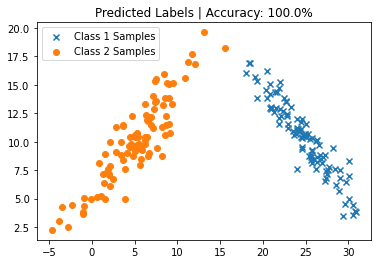

In [ ]:
# Easy separation Data
(TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 100, mean1 = [5,10], mean2 = [25, 10], stds1 = [10, 10, 9, 9], stds2 = [9, 9, -8.5, -8.5]) 

model = train_graph(SamplesAll)
#print(model)
predicted_labels = predict_graph(model)
accuracy = test_graph_cut(predicted_labels, TargetsAll)
plotSampleData(SamplesAll, predicted_labels, show_separated=True, show_plot=True, title=f"Predicted Labels | Accuracy: {accuracy}%")


================== Iteration: 1 ==================



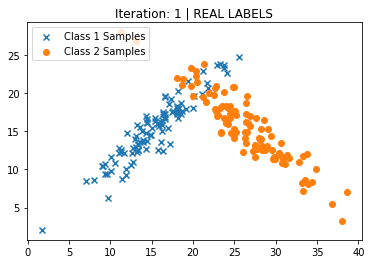

-----------------------------------------------
Cut node: 89, weight: 8.368782043457031, vertices [89]


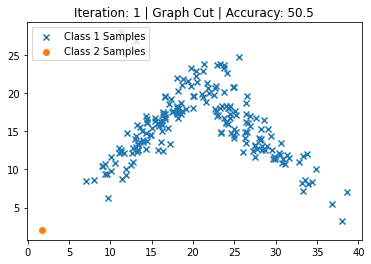


================== Iteration: 2 ==================



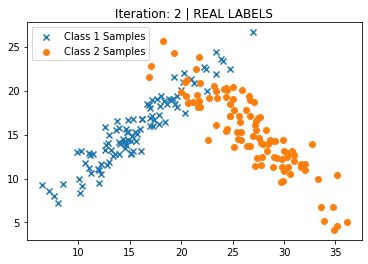

-----------------------------------------------
Cut node: 69, weight: 4.258937835693359, vertices [69]


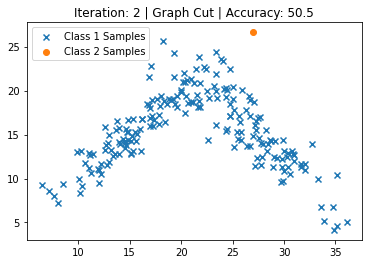


================== Iteration: 3 ==================



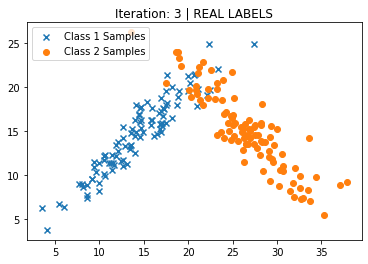

-----------------------------------------------
Cut node: 197, weight: 5.616888523101807, vertices [197]


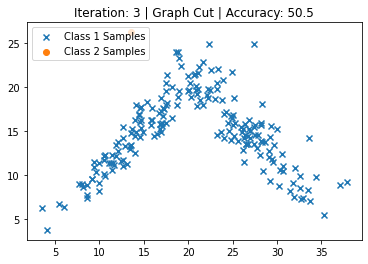


================== Iteration: 4 ==================



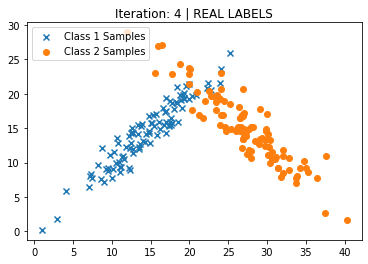

-----------------------------------------------
Cut node: 105, weight: 5.173798084259033, vertices [105, 112]


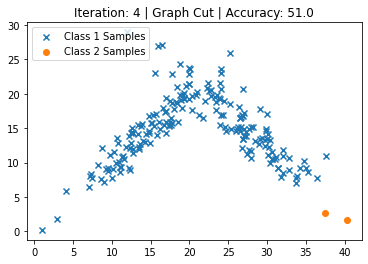


================== Iteration: 5 ==================



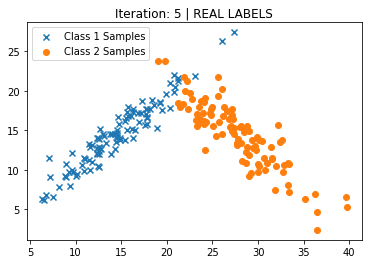

-----------------------------------------------
Cut node: 12, weight: 4.633517265319824, vertices [12, 22]


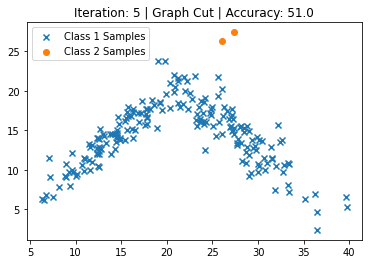


================== Iteration: 6 ==================



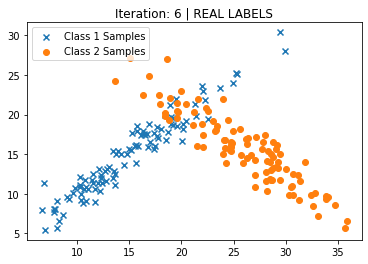

-----------------------------------------------
Cut node: 27, weight: 5.407107830047607, vertices [27, 57]


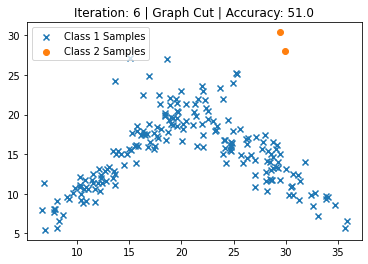


================== Iteration: 7 ==================



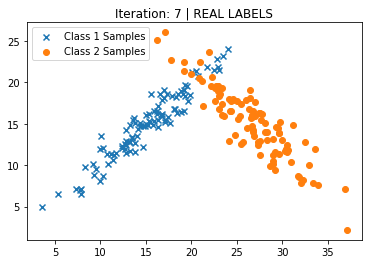

-----------------------------------------------
Cut node: 165, weight: 4.949389934539795, vertices [165]


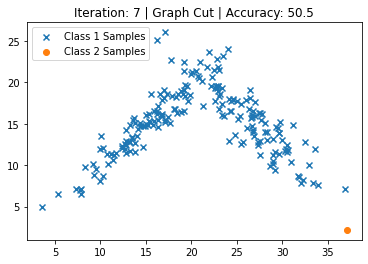


================== Iteration: 8 ==================



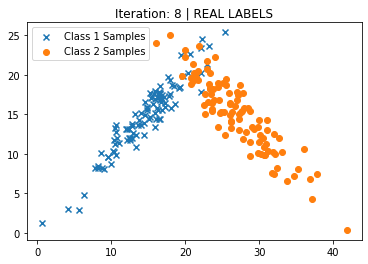

-----------------------------------------------
Cut node: 149, weight: 6.101327419281006, vertices [149]


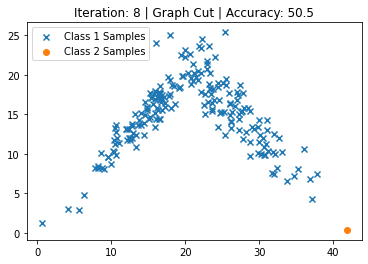


================== Iteration: 9 ==================



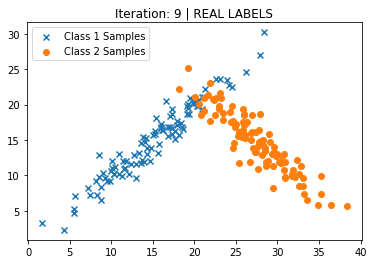

-----------------------------------------------
Cut node: 24, weight: 3.2023818492889404, vertices [24]


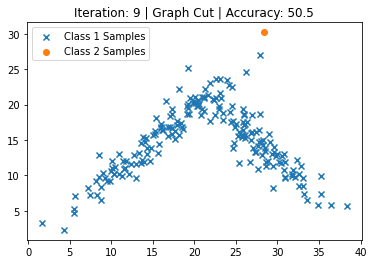


================== Iteration: 10 ==================



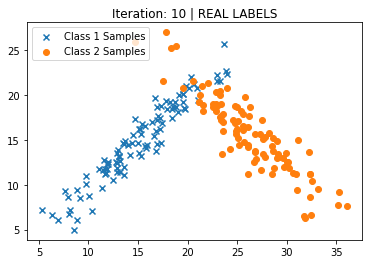

-----------------------------------------------
Cut node: 104, weight: 3.6841881275177, vertices [104, 122, 129, 112]


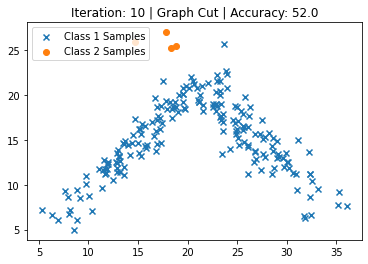

Graph Cut Algorithm
== Accuracy ==
Std: 0.483
Mean: 50.8
== Time ==
Std: 0.008
Mean: 0.51


In [ ]:
# # Hard separation data
# (TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 100, mean1 = [15,15], mean2 = [27, 15], stds1 = [20, 20, 19, 19], stds2 = [19, 19, -17, -17]) 
# model = train_graph(SamplesAll)
# #print(model)
# predicted_labels = predict_graph(model)
# accuracy = test_graph_cut(predicted_labels, TargetsAll)
# plotSampleData(SamplesAll, predicted_labels, show_separated=True, show_plot=True, title=f"Predicted Labels | Accuracy: {accuracy}%")


# Number of iterations
iterations = 10

# To save accuraccies
accuracies = torch.zeros(2, iterations)

# To save times
times = torch.zeros(2, iterations)

for iteration in range(iterations):
  print(f'\n================== Iteration: {iteration + 1} ==================\n')
  
  # Create Data  
  (TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 100, mean1 = [15,15], mean2 = [27, 15], stds1 = [20, 20, 19, 19], stds2 = [19, 19, -17, -17]) 

  # Plot real data
  plotSampleData(SamplesAll, TargetsAll, show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | REAL LABELS")

  # Train Minimum spanning tree with Graph Cut
  start_time = time.time()
  model = train_graph(SamplesAll)
  times[0][iteration] = time.time() - start_time
  print("-----------------------------------------------")
  # Calc Accuracy
  predicted_labels = predict_graph(model)
  accuracies[0][iteration] = test_graph_cut(predicted_labels, TargetsAll)

  # Plot Predicted Labels
  plotSampleData(SamplesAll, predicted_labels, show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | Graph Cut | Accuracy: {accuracies[0][iteration]}")
  

print("Graph Cut Algorithm")
print("== Accuracy ==")
print("Std:", round(accuracies[0].std().item(), 3))
print("Mean:", round(accuracies[0].mean().item(), 3))

print("== Time ==")
print("Std:", round(times[0].std().item(), 3))
print("Mean:", round(times[0].mean().item(), 3))



#2.2 - Generación de dos medias lunas

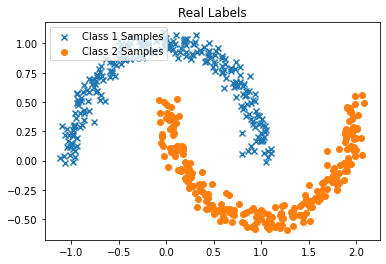

In [ ]:
x, y = make_moons(n_samples= 500, noise= 0.06)
TargetsAll = torch.tensor(y, dtype=torch.float)
SamplesAll = torch.tensor(x, dtype=torch.float).T
plotSampleData(SamplesAll, TargetsAll, title='Real Labels')


#2.3.a - Clasificación con algoritmo de Corte de grafos

Cut node: 334, weight: 0.34360232949256897, vertices [334, 435, 259, 408, 440, 129, 433, 314, 175, 409, 361, 450, 270, 244, 21, 19, 122, 311, 330, 468, 89, 38, 348, 209, 184, 202, 273, 52, 69, 352, 110, 331, 396, 10, 187, 403, 189, 155, 137, 303, 382, 326, 58, 205, 261, 341, 478, 126, 149, 480, 61, 472, 211, 164, 28, 329, 108, 198, 185, 13, 107, 255, 139, 0, 45, 112, 360, 359, 17, 148, 272, 96, 66, 31, 220, 99, 384, 298, 173, 32, 345, 327, 100, 380, 192, 176, 196, 43, 393, 76, 132, 168, 182, 350, 154, 80, 296, 84, 93, 289, 362, 414, 340, 65, 386, 321, 378, 55, 195, 133, 266, 15, 123, 194, 103, 424, 482, 121, 119, 64, 216, 246, 347, 328, 387, 12, 418, 446, 388, 475, 101, 410, 283, 346, 212, 181, 234, 177, 415, 174, 385, 206, 490, 399, 41, 357, 367, 499, 170, 258, 426, 486, 454, 210, 404, 53, 73, 208, 368, 491, 49, 292, 68, 260, 83, 217, 423, 222, 447, 113, 421, 412, 363, 343, 353, 51, 256, 33, 179, 201, 102, 371, 335, 453, 227, 2, 160, 158, 162, 178, 70, 323, 104, 301, 351, 488, 109, 22

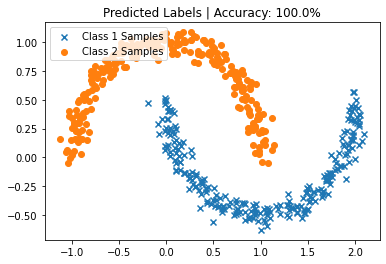

In [ ]:
model = train_graph(SamplesAll)
predicted_labels = predict_graph(model)
accuracy = test_graph_cut(predicted_labels, TargetsAll)
plotSampleData(SamplesAll, predicted_labels, show_separated=True, show_plot=True, title=f"Predicted Labels | Accuracy: {accuracy}%")

# 2.3.b - Tasa de aciertos de varias iteraciones del algoritmo de Corte de grafos


================== Iteration: 1 ==================



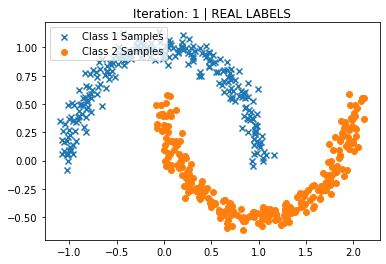

-----------------------------------------------
Cut node: 133, weight: 0.2644774317741394, vertices [133, 467, 55, 361, 245, 432, 127, 5, 50, 328, 320, 42, 339, 323, 33, 259, 454, 180, 420, 109, 99, 178, 440, 377, 227, 67, 310, 101, 43, 4, 238, 475, 336, 477, 23, 218, 304, 349, 286, 391, 181, 358, 21, 332, 89, 10, 143, 49, 461, 356, 211, 105, 383, 207, 129, 404, 406, 441, 88, 159, 257, 275, 300, 36, 213, 202, 251, 362, 385, 100, 184, 139, 253, 24, 357, 14, 294, 390, 363, 476, 430, 256, 161, 456, 316, 444, 474, 368, 229, 478, 466, 428, 458, 34, 52, 405, 149, 47, 326, 258, 309, 308, 7, 32, 234, 329, 291, 176, 301, 442, 303, 462, 307, 493, 322, 252, 182, 306, 1, 244, 66, 140, 472, 86, 434, 411, 460, 429, 185, 409, 255, 350, 382, 376, 236, 170, 417, 287, 71, 292, 311, 366, 488, 30, 352, 15, 121, 285, 95, 123, 80, 272, 451, 450, 446, 266, 2, 74, 282, 0, 225, 425, 337, 342, 480, 473, 399, 146, 263, 26, 381, 158, 289, 91, 241, 169, 72, 281, 197, 163, 401, 148, 79, 261, 388, 16, 68, 226, 246, 

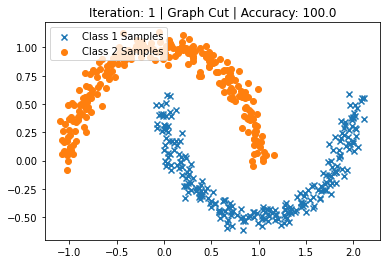


================== Iteration: 2 ==================



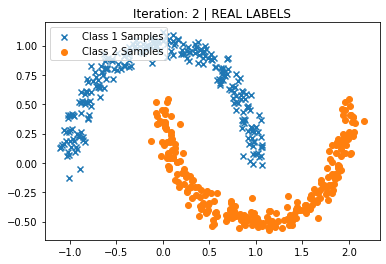

-----------------------------------------------
Cut node: 148, weight: 0.2940632998943329, vertices [148, 325, 198, 118, 181, 124, 90, 205, 237, 251, 69, 67, 180, 160, 436, 40, 242, 386, 131, 206, 185, 125, 236, 434, 429, 324, 82, 449, 482, 15, 150, 158, 153, 137, 437, 430, 25, 87, 395, 178, 443, 473, 59, 172, 4, 415, 316, 375, 344, 75, 354, 128, 380, 219, 271, 464, 402, 143, 112, 14, 416, 294, 6, 394, 74, 195, 290, 155, 330, 260, 409, 283, 17, 385, 37, 320, 403, 431, 280, 111, 28, 494, 32, 327, 115, 352, 488, 248, 179, 11, 36, 474, 441, 329, 19, 462, 388, 176, 107, 89, 373, 213, 218, 301, 389, 298, 192, 49, 255, 29, 477, 299, 277, 142, 217, 418, 372, 136, 399, 498, 292, 276, 202, 93, 470, 113, 291, 210, 246, 232, 432, 414, 120, 273, 315, 317, 27, 85, 138, 109, 231, 208, 396, 361, 230, 211, 284, 151, 484, 91, 100, 139, 369, 408, 31, 392, 258, 400, 256, 331, 282, 318, 281, 364, 121, 497, 499, 99, 285, 103, 440, 250, 425, 272, 287, 105, 238, 129, 57, 21, 104, 419, 22, 420, 478, 456, 483,

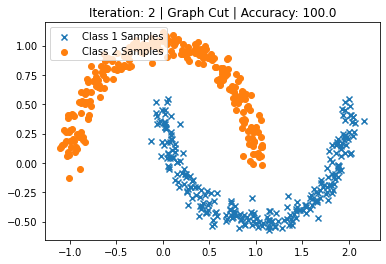


================== Iteration: 3 ==================



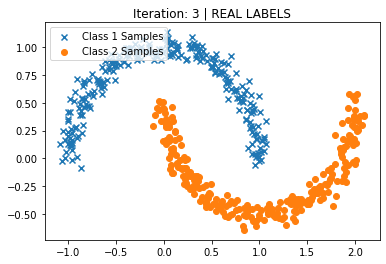

-----------------------------------------------
Cut node: 91, weight: 0.36634713411331177, vertices [91, 166, 409, 89, 400, 18, 222, 467, 163, 459, 381, 488, 479, 256, 129, 187, 25, 489, 263, 122, 226, 159, 114, 325, 425, 153, 179, 192, 205, 247, 283, 385, 445, 214, 449, 182, 298, 328, 436, 476, 310, 303, 218, 64, 30, 76, 464, 377, 404, 196, 351, 79, 432, 49, 169, 24, 460, 314, 73, 383, 402, 301, 139, 7, 468, 107, 370, 484, 376, 367, 36, 137, 95, 78, 251, 403, 257, 223, 206, 143, 57, 15, 106, 494, 243, 356, 422, 279, 337, 426, 148, 217, 387, 472, 284, 29, 338, 379, 71, 172, 438, 392, 58, 181, 431, 427, 255, 412, 406, 135, 102, 307, 433, 125, 46, 308, 441, 420, 342, 140, 216, 299, 273, 155, 175, 452, 277, 248, 429, 378, 252, 359, 473, 486, 421, 316, 128, 347, 276, 211, 253, 111, 87, 227, 117, 333, 194, 152, 382, 21, 350, 72, 237, 340, 326, 112, 177, 305, 343, 264, 335, 319, 487, 322, 77, 167, 188, 147, 304, 198, 101, 176, 414, 121, 270, 75, 230, 162, 282, 269, 158, 3, 415, 456, 157, 220

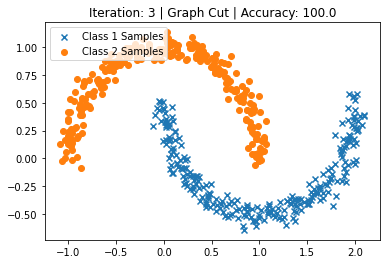


================== Iteration: 4 ==================



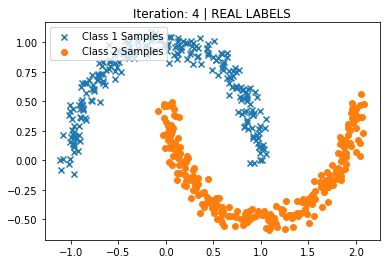

-----------------------------------------------
Cut node: 441, weight: 0.3369954228401184, vertices [441, 360, 4, 377, 275, 406, 479, 369, 433, 227, 306, 355, 492, 168, 424, 205, 91, 152, 465, 489, 184, 7, 22, 51, 339, 336, 53, 325, 67, 494, 387, 33, 163, 402, 391, 234, 448, 366, 177, 432, 367, 198, 423, 466, 294, 439, 43, 405, 452, 185, 398, 288, 231, 469, 384, 130, 409, 468, 266, 358, 143, 145, 421, 172, 61, 84, 328, 430, 62, 464, 357, 487, 31, 113, 323, 245, 247, 133, 23, 16, 213, 444, 353, 265, 278, 400, 455, 124, 29, 1, 225, 214, 126, 127, 3, 483, 193, 37, 274, 481, 271, 361, 107, 349, 160, 117, 385, 471, 121, 194, 308, 313, 395, 380, 232, 38, 112, 6, 165, 363, 94, 352, 175, 337, 176, 182, 270, 291, 388, 178, 221, 300, 240, 467, 47, 207, 368, 347, 171, 389, 74, 57, 482, 59, 354, 404, 106, 476, 24, 136, 35, 412, 262, 346, 350, 241, 63, 72, 99, 458, 326, 167, 81, 88, 436, 122, 285, 40, 186, 190, 220, 36, 490, 76, 327, 297, 319, 345, 195, 314, 101, 416, 65, 293, 164, 480, 154, 144, 2

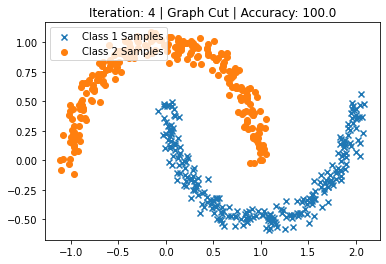


================== Iteration: 5 ==================



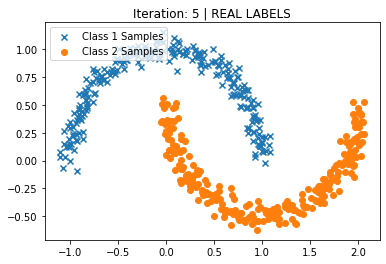

-----------------------------------------------
Cut node: 279, weight: 0.27364346385002136, vertices [279, 292, 107, 267, 241, 462, 266, 347, 73, 187, 123, 230, 454, 319, 204, 470, 450, 324, 455, 431, 218, 102, 29, 445, 132, 239, 52, 55, 412, 129, 22, 257, 113, 326, 101, 370, 252, 495, 457, 60, 51, 70, 27, 358, 87, 332, 48, 345, 44, 349, 173, 381, 225, 177, 103, 475, 461, 61, 77, 100, 456, 344, 346, 47, 459, 30, 276, 384, 251, 399, 336, 339, 152, 482, 34, 120, 354, 421, 208, 18, 398, 139, 411, 365, 259, 117, 379, 410, 78, 63, 415, 401, 57, 243, 260, 112, 197, 472, 284, 58, 443, 199, 254, 295, 232, 297, 446, 244, 308, 330, 287, 493, 174, 98, 281, 95, 414, 42, 377, 464, 465, 11, 375, 481, 274, 122, 111, 498, 0, 36, 294, 210, 1, 357, 235, 32, 248, 178, 387, 247, 91, 245, 118, 66, 490, 290, 258, 288, 238, 127, 7, 3, 413, 8, 28, 343, 86, 369, 17, 89, 146, 14, 115, 423, 463, 90, 320, 371, 393, 237, 236, 333, 407, 154, 442, 2, 157, 373, 19, 203, 337, 75, 4, 162, 106, 479, 184, 130, 43, 256, 4

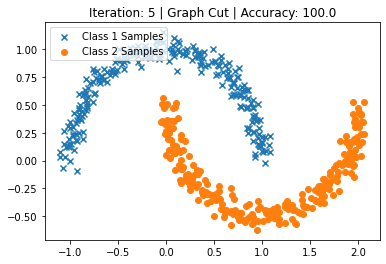


================== Iteration: 6 ==================



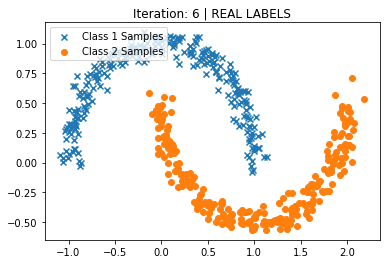

-----------------------------------------------
Cut node: 419, weight: 0.267549604177475, vertices [419, 255, 327, 204, 398, 485, 404, 13, 149, 140, 103, 406, 252, 304, 45, 455, 326, 29, 53, 207, 117, 14, 253, 216, 400, 272, 217, 257, 481, 426, 263, 163, 416, 347, 445, 332, 57, 322, 431, 422, 248, 295, 54, 418, 173, 479, 155, 349, 328, 5, 336, 101, 190, 31, 241, 353, 42, 480, 174, 64, 40, 282, 1, 466, 410, 27, 25, 220, 56, 78, 113, 128, 442, 319, 228, 245, 450, 375, 234, 43, 24, 112, 0, 260, 4, 299, 240, 125, 68, 294, 108, 393, 423, 258, 114, 329, 274, 182, 93, 320, 391, 276, 120, 286, 469, 470, 383, 302, 201, 459, 388, 458, 301, 321, 141, 209, 482, 26, 17, 62, 146, 478, 83, 490, 434, 356, 366, 147, 477, 198, 395, 493, 131, 405, 438, 268, 215, 89, 213, 46, 157, 19, 197, 281, 447, 135, 130, 487, 293, 296, 74, 227, 179, 284, 94, 331, 351, 144, 168, 49, 385, 368, 303, 237, 453, 35, 158, 475, 312, 151, 69, 171, 363, 160, 358, 172, 343, 308, 309, 32, 244, 444, 210, 8, 65, 401, 22, 287, 413,

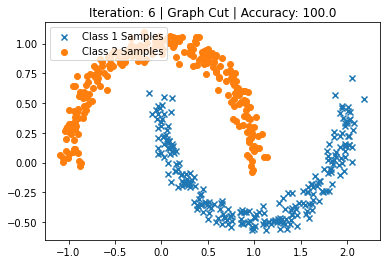


================== Iteration: 7 ==================



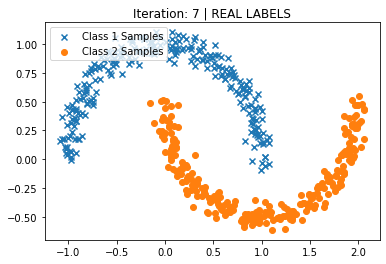

-----------------------------------------------
Cut node: 132, weight: 0.263916015625, vertices [132, 150, 91, 326, 384, 405, 104, 201, 439, 57, 174, 127, 189, 230, 5, 136, 56, 334, 85, 311, 455, 76, 98, 106, 210, 353, 65, 114, 9, 238, 102, 62, 212, 120, 397, 440, 403, 73, 383, 305, 138, 273, 348, 355, 143, 152, 232, 341, 312, 318, 207, 129, 492, 268, 483, 175, 433, 199, 249, 387, 285, 122, 69, 180, 49, 167, 20, 134, 307, 363, 53, 187, 453, 493, 89, 308, 275, 67, 64, 263, 423, 340, 10, 464, 450, 373, 105, 290, 368, 41, 286, 331, 204, 206, 119, 99, 415, 158, 320, 176, 87, 38, 425, 31, 467, 170, 82, 451, 276, 350, 270, 322, 59, 81, 55, 302, 443, 156, 72, 422, 195, 246, 181, 489, 480, 27, 60, 445, 177, 242, 70, 272, 442, 51, 306, 361, 79, 411, 190, 63, 392, 429, 343, 365, 338, 293, 278, 498, 162, 165, 196, 108, 454, 485, 404, 151, 333, 284, 23, 264, 103, 297, 217, 186, 15, 385, 253, 408, 329, 325, 358, 50, 447, 316, 234, 413, 161, 417, 80, 469, 310, 288, 148, 240, 295, 266, 216, 375, 12, 

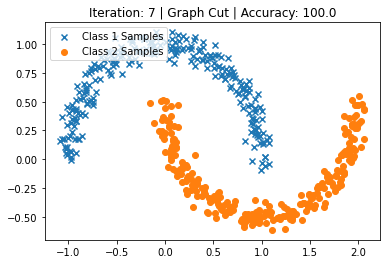


================== Iteration: 8 ==================



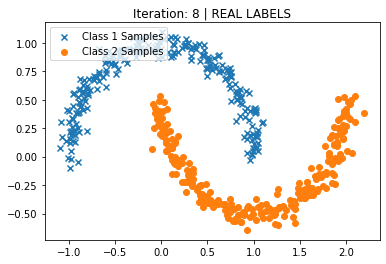

-----------------------------------------------
Cut node: 337, weight: 0.33939245343208313, vertices [337, 437, 176, 134, 399, 63, 453, 96, 211, 338, 291, 490, 59, 474, 368, 125, 433, 50, 382, 163, 106, 410, 363, 185, 35, 358, 245, 43, 3, 94, 65, 387, 292, 130, 180, 135, 55, 487, 90, 38, 492, 304, 168, 254, 234, 486, 28, 115, 381, 39, 146, 334, 209, 364, 117, 449, 269, 61, 440, 335, 205, 123, 411, 92, 250, 207, 141, 390, 473, 85, 417, 281, 22, 282, 149, 336, 265, 97, 206, 355, 13, 297, 476, 362, 62, 237, 294, 289, 53, 272, 415, 181, 137, 408, 52, 458, 309, 93, 280, 76, 152, 419, 1, 2, 432, 225, 56, 471, 120, 493, 287, 306, 366, 128, 78, 459, 99, 379, 219, 378, 104, 430, 386, 423, 327, 373, 353, 103, 98, 81, 143, 212, 469, 30, 332, 223, 46, 44, 213, 40, 101, 244, 347, 305, 321, 54, 367, 462, 242, 300, 303, 341, 357, 58, 348, 218, 197, 251, 454, 155, 365, 320, 83, 497, 222, 396, 172, 350, 271, 25, 201, 200, 288, 66, 68, 21, 375, 286, 24, 472, 383, 174, 71, 477, 175, 435, 105, 422, 169, 4

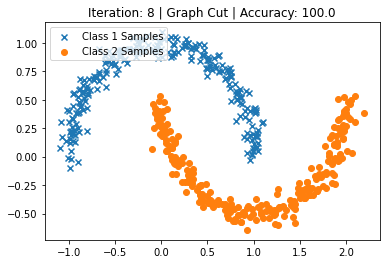


================== Iteration: 9 ==================



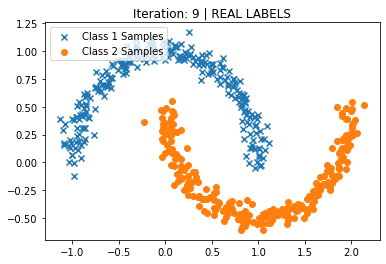

-----------------------------------------------
Cut node: 160, weight: 0.29897230863571167, vertices [160, 166, 97, 143, 462, 478, 405, 349, 68, 211, 148, 318, 121, 323, 451, 141, 147, 65, 169, 103, 457, 431, 454, 356, 321, 385, 213, 461, 192, 240, 16, 29, 178, 81, 54, 416, 340, 74, 64, 28, 239, 41, 485, 78, 324, 381, 341, 312, 352, 127, 357, 105, 5, 393, 364, 126, 438, 209, 176, 483, 20, 358, 163, 429, 88, 396, 14, 301, 200, 447, 130, 44, 149, 339, 397, 484, 138, 313, 3, 156, 135, 218, 8, 225, 350, 497, 492, 490, 415, 437, 80, 270, 172, 468, 455, 326, 408, 100, 330, 380, 181, 137, 83, 115, 15, 31, 1, 362, 439, 12, 407, 375, 116, 289, 332, 95, 157, 470, 411, 419, 164, 145, 210, 486, 222, 299, 70, 448, 337, 86, 175, 377, 481, 67, 27, 228, 136, 369, 258, 237, 268, 400, 452, 308, 52, 354, 305, 300, 309, 435, 373, 246, 498, 329, 162, 474, 365, 253, 60, 304, 390, 9, 325, 291, 187, 106, 202, 22, 151, 90, 368, 112, 273, 0, 11, 420, 259, 17, 343, 412, 348, 204, 471, 432, 487, 446, 190, 235, 18

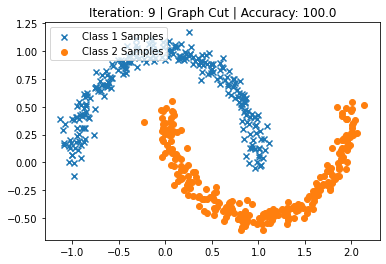


================== Iteration: 10 ==================



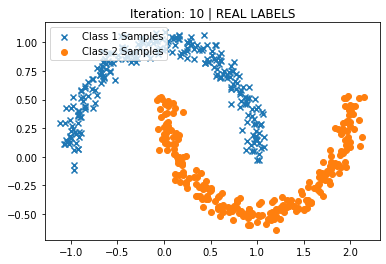

-----------------------------------------------
Cut node: 299, weight: 0.365850567817688, vertices [299, 323, 395, 236, 41, 112, 28, 1, 165, 449, 450, 130, 142, 178, 457, 194, 310, 14, 90, 116, 203, 356, 425, 205, 473, 121, 75, 118, 269, 294, 113, 164, 419, 364, 168, 184, 363, 53, 131, 2, 134, 343, 13, 463, 138, 297, 441, 15, 442, 22, 96, 29, 367, 212, 182, 115, 404, 34, 136, 494, 64, 139, 107, 195, 440, 336, 188, 272, 69, 492, 58, 471, 81, 183, 144, 295, 455, 122, 68, 469, 349, 355, 71, 185, 230, 296, 282, 78, 114, 268, 315, 388, 26, 482, 317, 414, 97, 477, 228, 389, 9, 357, 462, 277, 387, 316, 252, 392, 423, 373, 472, 63, 6, 286, 321, 176, 33, 200, 35, 263, 270, 445, 47, 166, 300, 313, 106, 285, 61, 346, 369, 340, 394, 368, 224, 275, 240, 4, 44, 127, 0, 409, 353, 342, 50, 174, 146, 169, 60, 59, 104, 124, 154, 10, 177, 221, 258, 393, 238, 407, 416, 351, 344, 304, 429, 54, 358, 439, 145, 197, 155, 86, 226, 303, 259, 214, 319, 428, 436, 402, 208, 287, 312, 179, 45, 83, 498, 330, 18, 453

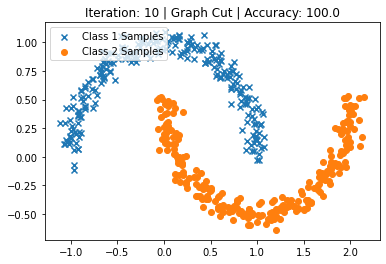

Graph Cut Algorithm
== Accuracy ==
Std: 0.0
Mean: 100.0
== Time ==
Std: 0.085
Mean: 3.994


In [ ]:
# Number of iterations
iterations = 10

# To save accuraccies
accuracies = torch.zeros(2, iterations)

# To save times
times = torch.zeros(2, iterations)

for iteration in range(iterations):
  print(f'\n================== Iteration: {iteration + 1} ==================\n')
  
  # Create Data  
  x, y = make_moons(n_samples= 500, noise= 0.06)
  TargetsAll = torch.tensor(y, dtype=torch.float)
  SamplesAll = torch.tensor(x, dtype=torch.float).T 

  # Plot real data
  plotSampleData(SamplesAll, TargetsAll, show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | REAL LABELS")

  # Train Minimum spanning tree with Graph Cut
  start_time = time.time()
  model = train_graph(SamplesAll)
  times[0][iteration] = time.time() - start_time
  print("-----------------------------------------------")
  # Calc Accuracy
  predicted_labels = predict_graph(model)
  accuracies[0][iteration] = test_graph_cut(predicted_labels, TargetsAll)

  # Plot Predicted Labels
  plotSampleData(SamplesAll, predicted_labels, show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | Graph Cut | Accuracy: {accuracies[0][iteration]}")
  

print("Graph Cut Algorithm")
print("== Accuracy ==")
print("Std:", round(accuracies[0].std().item(), 3))
print("Mean:", round(accuracies[0].mean().item(), 3))

print("== Time ==")
print("Std:", round(times[0].std().item(), 3))
print("Mean:", round(times[0].mean().item(), 3))


#2.3.c - Clasificación con algoritmo de K-medias con dos medias lunas


================== Iteration: 1 ==================



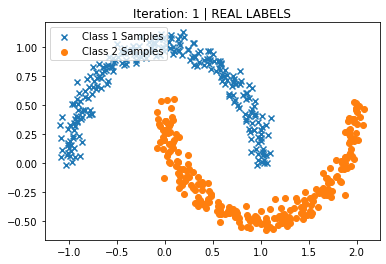

-----------------------------------------------


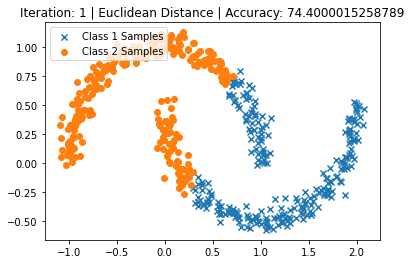

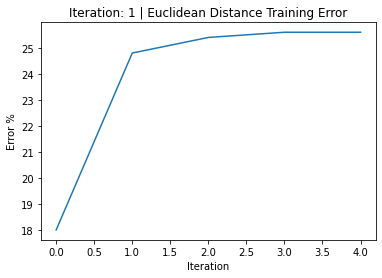

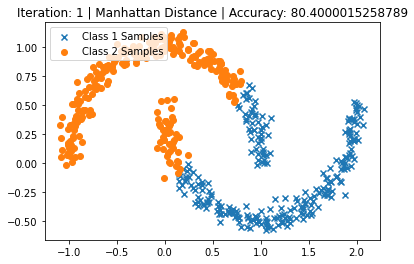

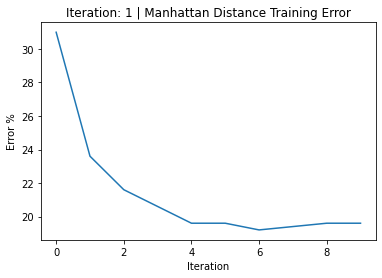


================== Iteration: 2 ==================



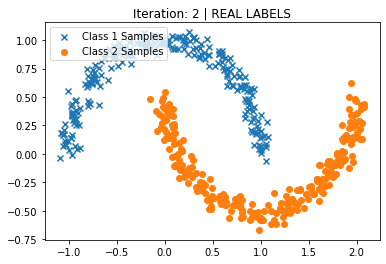

-----------------------------------------------


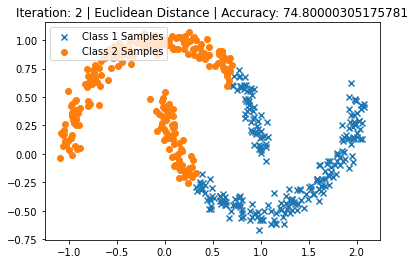

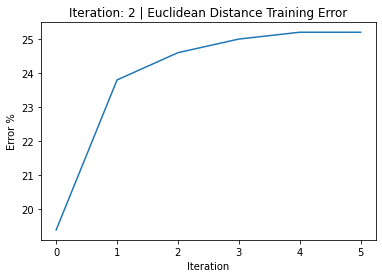

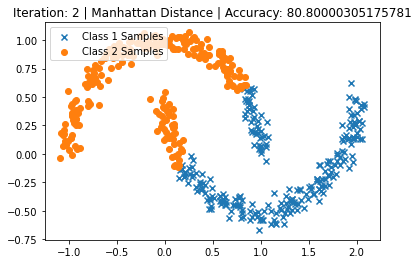

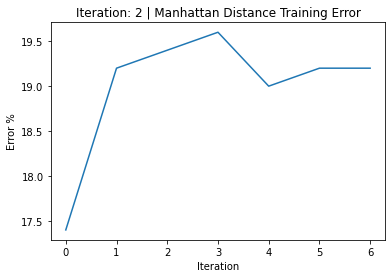


================== Iteration: 3 ==================



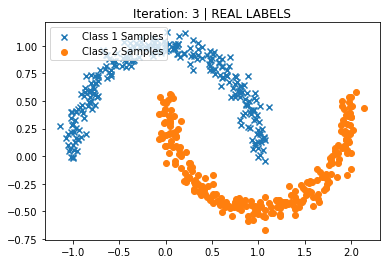

-----------------------------------------------


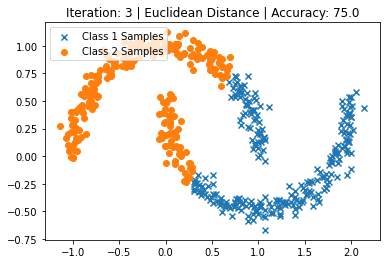

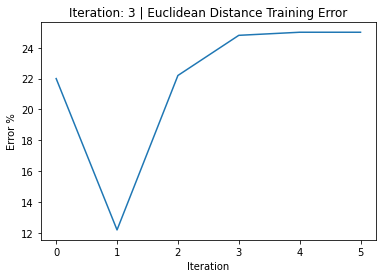

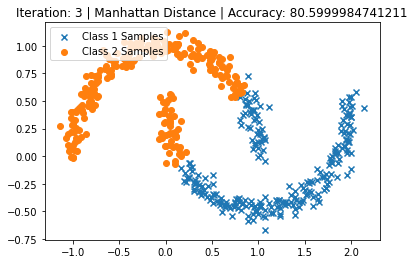

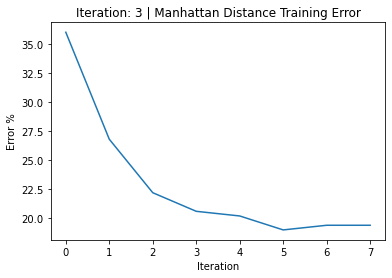


================== Iteration: 4 ==================



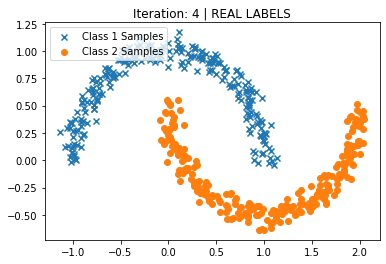

-----------------------------------------------


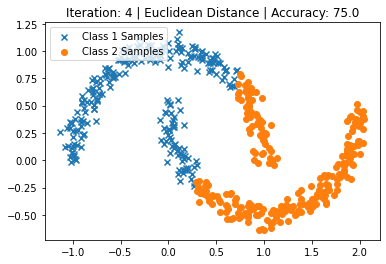

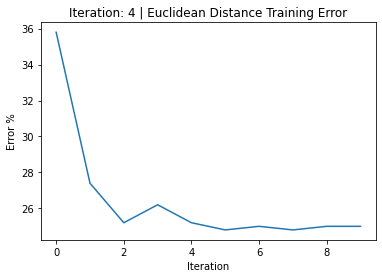

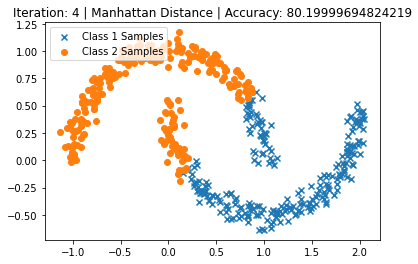

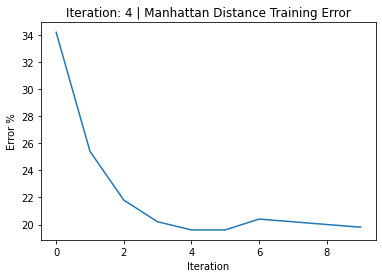


================== Iteration: 5 ==================



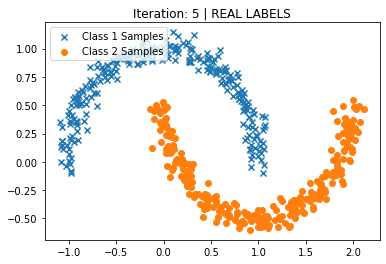

-----------------------------------------------


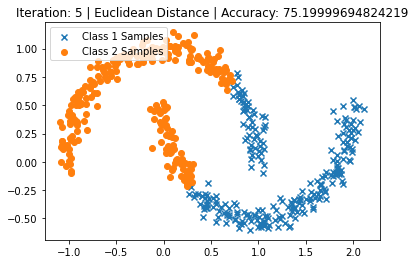

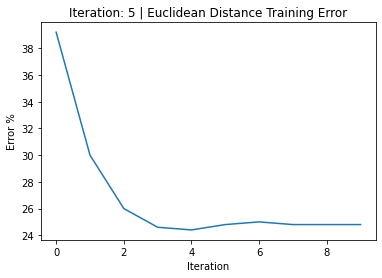

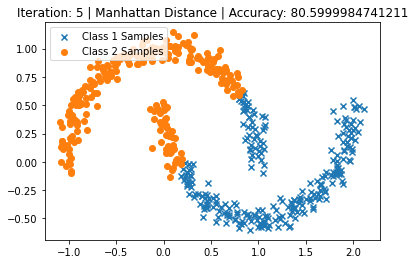

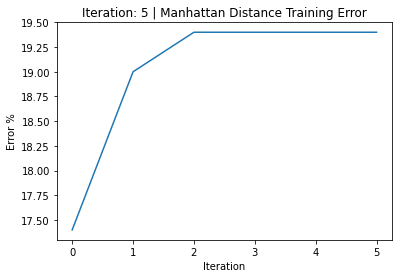


================== Iteration: 6 ==================



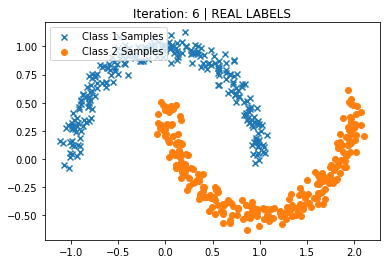

-----------------------------------------------


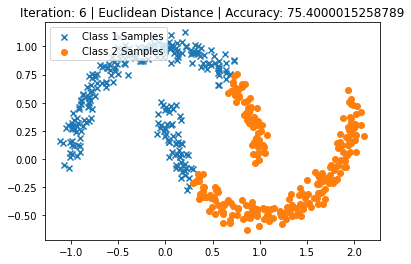

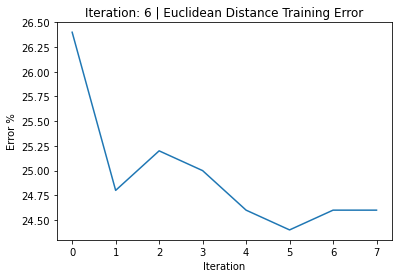

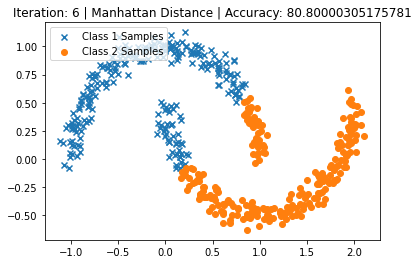

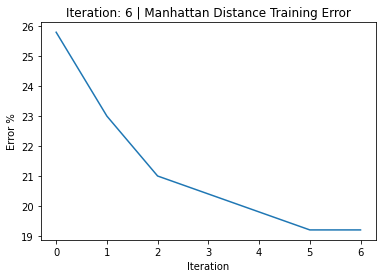


================== Iteration: 7 ==================



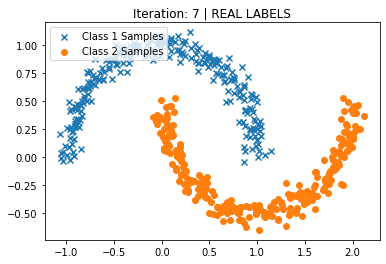

-----------------------------------------------


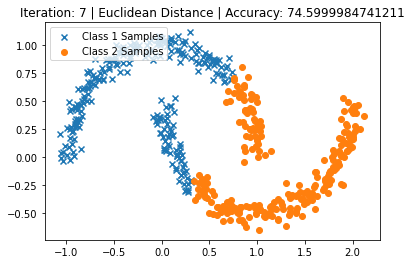

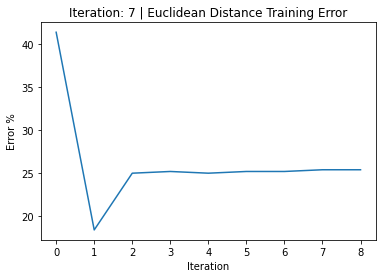

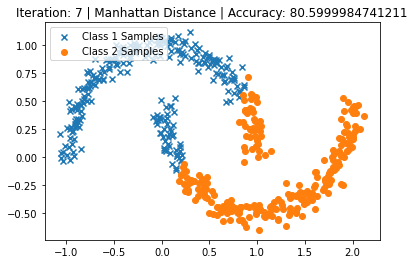

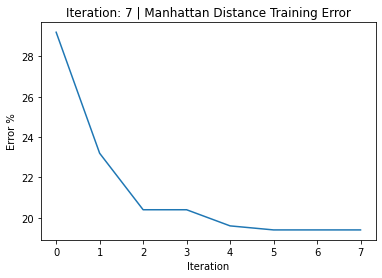


================== Iteration: 8 ==================



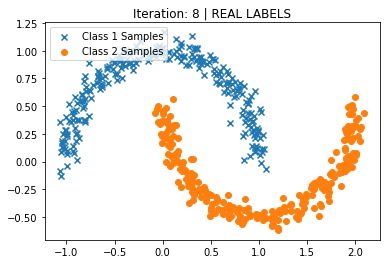

-----------------------------------------------


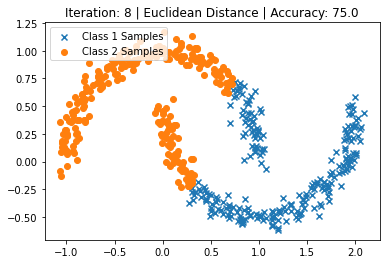

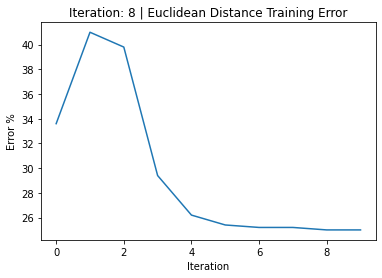

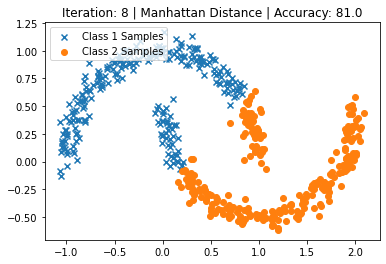

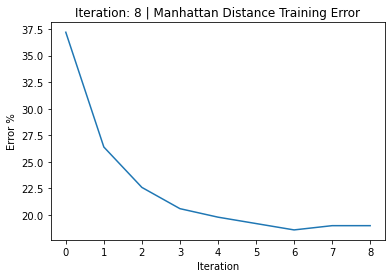


================== Iteration: 9 ==================



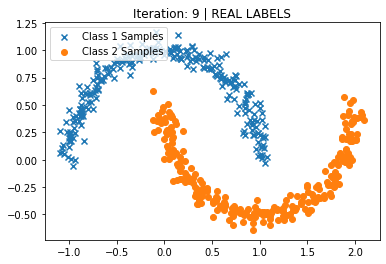

-----------------------------------------------


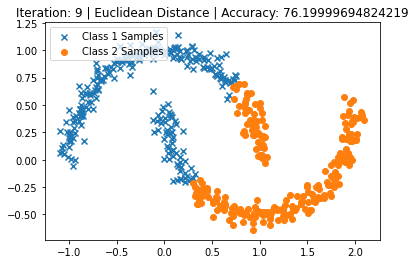

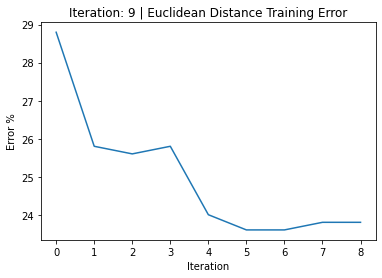

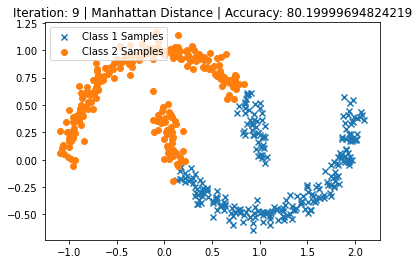

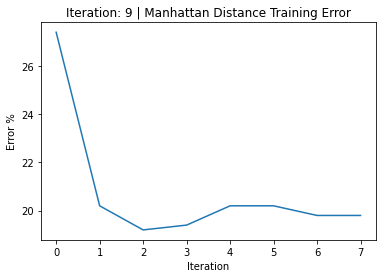


================== Iteration: 10 ==================



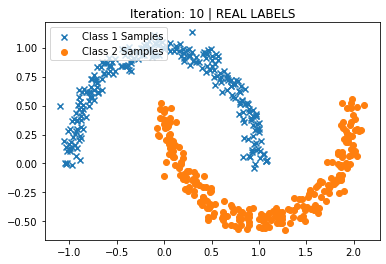

-----------------------------------------------


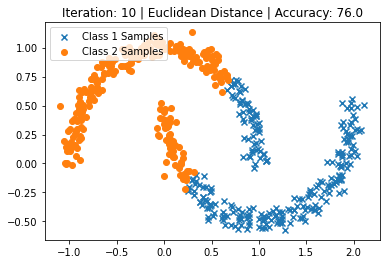

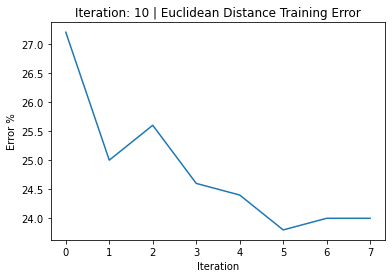

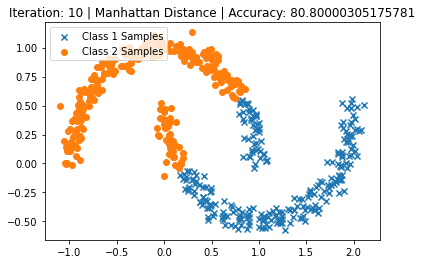

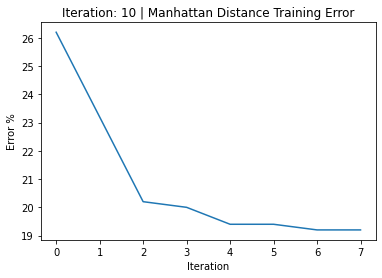


EUCLIDEAN DISTANCE
== Accuracy ==
Std: 0.572
Mean: 75.16
== Time ==
Std: 0.003
Mean: 0.011

MANHATTAN DISTANCE
== Accuracy ==
Std: 0.267
Mean: 80.6
== Time ==
Std: 0.001
Mean: 0.006


In [ ]:
# Number of iterations
iterations = 10

# To save accuraccies
accuracies = torch.zeros(2, iterations)

# To save times
times = torch.zeros(2, iterations)

for iteration in range(iterations):
  print(f'\n================== Iteration: {iteration + 1} ==================\n')
  
  # Create Data
  x, y = make_moons(n_samples= 500, noise= 0.06)
  TargetsAll = torch.tensor(y, dtype=torch.float)
  SamplesAll = torch.tensor(x, dtype=torch.float).T 

  # Plot real data
  plotSampleData(SamplesAll, TargetsAll, show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | REAL LABELS")

  # == EUCLIDEAN DISTANCE == #
  # Train W Matrix Using: [Euclidean Distance]
  start_time = time.time()
  W, allLosses = Train_K_Means(euclidean=True, show_plot=False)
  times[0][iteration] = time.time() - start_time
  print("-----------------------------------------------")
  # Calc Accuracy
  accuracies[0][iteration] = Test_K_Means(W, TargetsAll)

  # Plot Predicted Labels
  plotSampleData(SamplesAll, predict(W), show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | Euclidean Distance | Accuracy: {accuracies[0][iteration]}")
  plotError(allLosses, f"Iteration: {iteration + 1} | Euclidean Distance Training Error")
  # == EUCLIDEAN DISTANCE == #

  # == MANHATTAN DISTANCE == #
  # Train W Matrix Using: [Manhattan Distance]
  start_time = time.time()
  W, allLosses = Train_K_Means(euclidean=False, show_plot=False)
  times[1][iteration] = time.time() - start_time

  # Calc Accuracy
  accuracies[1][iteration] = Test_K_Means(W, TargetsAll)

  # Plot Predicted Labels
  plotSampleData(SamplesAll, predict(W), show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | Manhattan Distance | Accuracy: {accuracies[1][iteration]}")
  plotError(allLosses, f"Iteration: {iteration + 1} | Manhattan Distance Training Error")
  # == MANHATTAN DISTANCE == #

print("\nEUCLIDEAN DISTANCE")
print("== Accuracy ==")
print("Std:", round(accuracies[0].std().item(), 3))
print("Mean:", round(accuracies[0].mean().item(), 3))

print("== Time ==")
print("Std:", round(times[0].std().item(), 3))
print("Mean:", round(times[0].mean().item(), 3))

print("\nMANHATTAN DISTANCE")
print("== Accuracy ==")
print("Std:", round(accuracies[1].std().item(), 3))
print("Mean:", round(accuracies[1].mean().item(), 3))

print("== Time ==")
print("Std:", round(times[1].std().item(), 3))
print("Mean:", round(times[1].mean().item(), 3))